***DATA SCIENCE INTERN AT LETSGROWMORE LGMVIPDECEMBER NAME: AVISHKAR DIGE TASK 8 : Next Word Prediction***

In [55]:
import numpy as np
from nltk.tokenize import RegexpTokenizer
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM
from keras.layers.core import Dense, Activation
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import pickle
import heapq

In [44]:
text = open('1661-0.txt' ,encoding ='UTF-8').read().lower()
print('corpus length:', len(text))

corpus length: 581888


In [45]:
tokenizer = RegexpTokenizer(r'\w+')
words = tokenizer.tokenize(text)

In [46]:
unique_words = np.unique(words)
unique_word_index = dict((c, i) for i, c in enumerate(unique_words))

In [47]:
WORD_LENGTH = 5
prev_words = []
next_words = []
for i in range(len(words) - WORD_LENGTH):
    prev_words.append(words[i:i + WORD_LENGTH])
    next_words.append(words[i + WORD_LENGTH])
print(prev_words[0])
print(next_words[0])

['project', 'gutenberg', 's', 'the', 'adventures']
of


In [48]:
X = np.zeros((len(prev_words), WORD_LENGTH, len(unique_words)), dtype=bool)
Y = np.zeros((len(next_words), len(unique_words)), dtype=bool)
for i, each_words in enumerate(prev_words):
    for j, each_word in enumerate(each_words):
        X[i, j, unique_word_index[each_word]] = 1
    Y[i, unique_word_index[next_words[i]]] = 1

In [49]:
print(X[0][0])

[False False False ... False False False]


In [50]:
model = Sequential()
model.add(LSTM(128, input_shape=(WORD_LENGTH, len(unique_words))))
model.add(Dense(len(unique_words)))
model.add(Activation('softmax'))

In [51]:
optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(X, Y, validation_split=0.05, batch_size=128, epochs=10, shuffle=True).history

Epoch 1/10
811/811 [==============================] - 99s 121ms/step - loss: 6.0132 - accuracy: 0.1077 - val_loss: 7.1232 - val_accuracy: 0.0994
Epoch 2/10
811/811 [==============================] - 98s 120ms/step - loss: 5.7745 - accuracy: 0.1479 - val_loss: 7.8108 - val_accuracy: 0.1049
Epoch 3/10
811/811 [==============================] - 93s 115ms/step - loss: 5.7512 - accuracy: 0.1747 - val_loss: 8.0916 - val_accuracy: 0.1071
Epoch 4/10
811/811 [==============================] - 97s 120ms/step - loss: 5.4259 - accuracy: 0.2122 - val_loss: 8.2832 - val_accuracy: 0.1018
Epoch 5/10
811/811 [==============================] - 91s 112ms/step - loss: 5.0827 - accuracy: 0.2526 - val_loss: 8.5405 - val_accuracy: 0.1044
Epoch 6/10
811/811 [==============================] - 87s 108ms/step - loss: 4.7455 - accuracy: 0.2950 - val_loss: 8.5829 - val_accuracy: 0.0871
Epoch 7/10
811/811 [==============================] - 88s 109ms/step - loss: 4.4281 - accuracy: 0.3366 - val_loss: 8.8471 - val_ac

In [57]:
history

{'loss': [6.013178825378418,
  5.774477958679199,
  5.751172065734863,
  5.4258575439453125,
  5.082727909088135,
  4.745548725128174,
  4.428077697753906,
  4.150802135467529,
  3.9200966358184814,
  3.740877389907837],
 'accuracy': [0.10773041099309921,
  0.14794860780239105,
  0.17465472221374512,
  0.2122129201889038,
  0.2525853216648102,
  0.295020192861557,
  0.3366069495677948,
  0.3754180371761322,
  0.4121762812137604,
  0.44273748993873596],
 'val_loss': [7.123224258422852,
  7.810762882232666,
  8.091642379760742,
  8.283167839050293,
  8.540526390075684,
  8.58292007446289,
  8.847074508666992,
  9.102235794067383,
  9.62551498413086,
  9.469526290893555],
 'val_accuracy': [0.09941413253545761,
  0.10490662604570389,
  0.1071036234498024,
  0.10179421305656433,
  0.10435737669467926,
  0.08714756369590759,
  0.0891614779829979,
  0.08385206758975983,
  0.07579641044139862,
  0.07689490914344788]}

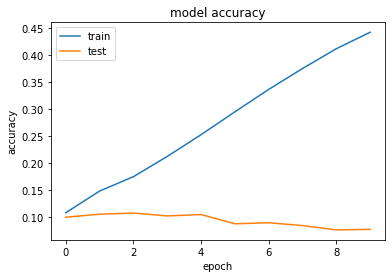

In [58]:
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

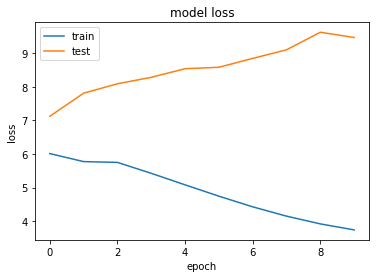

In [59]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

In [60]:
def prepare_input(text):
    x = np.zeros((1, WORD_LENGTH, len(unique_words)))
    for t, word in enumerate(text.split()):
        print(word)
        x[0, t, unique_word_index[word]] = 1
    return x
prepare_input("It is not a lack".lower())

it
is
not
a
lack


array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])

In [61]:
def sample(preds, top_n=3):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds)
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)

    return heapq.nlargest(top_n, range(len(preds)), preds.take)

In [62]:
def predict_completions(text, n=3):
    if text == "":
        return("0")
    x = prepare_input(text)
    preds = model.predict(x, verbose=0)[0]
    next_indices = sample(preds, n)
    return [unique_words[idx] for idx in next_indices]

In [63]:
q =  "There is nothing more deceptive than an obvious fact"
print("correct sentence: ",q)
seq = " ".join(tokenizer.tokenize(q.lower())[0:5])
print("Sequence: ",seq)
print("next possible words: ", predict_completions(seq, 5))

correct sentence:  There is nothing more deceptive than an obvious fact
Sequence:  there is nothing more deceptive
there
is
nothing
more
deceptive
next possible words:  ['than', 'to', 'what', 'are', 'about']
